In [1]:
import numpy as np
import pickle
import time
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Attention


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




Datasets successfully loaded.


Training/validation on 32450 samples (25 CCLs x 1298 DepOIs) and testing on 3894 samples (3 CCLs x 1298 DepOIs).


Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 7.5162 - val_loss: 0.1936
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1876 - val_loss: 0.1567
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1508 - val_loss: 0.0802
Epoch 4/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1051 - val_loss: 0.0593
Epoch 5/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0891 - val_loss: 0.0510
Epoch 6/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0758 - val_loss: 0.0496
Epoch 7/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0705 - val_loss: 0.0473
Epoch 8/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0659 - val_loss: 0.0466
Epoch 9/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0645 - val_loss: 0.0466
Epoch 10/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0624 - val_l

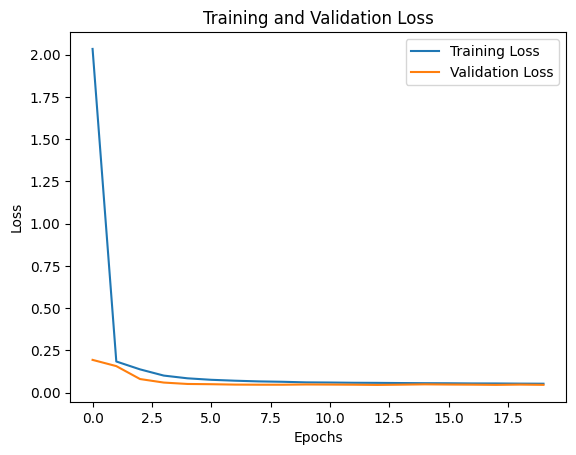


Evaluation metrics on test data:
MSE: 0.0427
RMSE: 0.2066
R-squared (R2): 0.7623
MAE: 0.1522
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Evaluation metrics on validation data:
MSE: 0.0460
RMSE: 0.2144
R-squared (R2): 0.7566
MAE: 0.1573

Binary Classification Metrics:
F1 Score: 0.6567
Recall (Sensitivity): 0.5171
Precision: 0.8995
Accuracy: 0.9471

Final training loss: 0.0526
Final validation loss: 0.0459


In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, Reshape
from tensorflow.keras.optimizers import Adam

if __name__ == '__main__':

    # Loading data
    with open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/ccl_complete_data_28CCL_1298DepOI_36344samples_demo.pickle', 'rb') as f:
        data_mut, data_exp, data_cna, data_meth, data_dep, data_fprint = pickle.load(f)

    # Loading pretrained models
    premodel_mut = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_mut_100_50_25_demo.pickle', 'rb'))
    premodel_exp = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_exp_100_50_25_demo.pickle', 'rb'))
    premodel_cna = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_cna_100_50_25_demo.pickle', 'rb'))
    premodel_meth = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_meth_100_50_25_demo.pickle', 'rb'))
    print("\n\nDatasets successfully loaded.")

    # model parameters
    activation_func = 'relu'  
    activation_func2 = 'linear'  
    init = 'he_uniform'
    dense_layer_dim_1 = 100  
    dense_layer_dim_2 = 150 
    batch_size = 64  
    num_epoch = 20  
    num_DepOI = 1298 
    num_ccl = int(data_mut.shape[0] / num_DepOI)

    # Spliting data into train/validation and test sets
    id_rand = np.random.permutation(num_ccl)
    id_cell_train = id_rand[np.arange(0, round(num_ccl * 0.9))]
    id_cell_test = id_rand[np.arange(round(num_ccl * 0.9), num_ccl)]

    id_train = np.arange(0, 1298) + id_cell_train[0] * 1298
    for y in id_cell_train:
        id_train = np.union1d(id_train, np.arange(0, 1298) + y * 1298)

    id_test = np.arange(0, 1298) + id_cell_test[0] * 1298
    for y in id_cell_test:
        id_test = np.union1d(id_test, np.arange(0, 1298) + y * 1298)

    print("\n\nTraining/validation on %d samples (%d CCLs x %d DepOIs) and testing on %d samples (%d CCLs x %d DepOIs).\n\n" % (
        len(id_train), len(id_cell_train), num_DepOI, len(id_test), len(id_cell_test), num_DepOI))


    # Defining subnetworks
    # input_mut = Input(shape=(premodel_mut[0][0].shape[0],))
    # x = Dense(100, activation=activation_func, trainable=True)(input_mut)
    # x = Dropout(0.3)(x)  # dropout_mut_1
    # x = Dense(50, activation=activation_func, trainable=True)(x)
    # x = Dropout(0.4)(x)  # dropout_mut_2
    # x = Dense(25, activation=activation_func, trainable=True)(x)
    # model_mut = models.Model(input_mut, x)

    input_exp = Input(shape=(premodel_exp[0][0].shape[0],))
    x = Dense(100, activation=activation_func, trainable=True)(input_exp)
    x = Dropout(0.2)(x)  # dropout_exp_1
    x = Dense(50, activation=activation_func, trainable=True)(x)
    x = Dropout(0.3)(x)  # dropout_exp_2
    x = Dense(25, activation=activation_func, trainable=True)(x)
    model_exp = models.Model(input_exp, x)

    # input_cna = Input(shape=(premodel_cna[0][0].shape[0],))
    # x = Dense(100, activation=activation_func, trainable=True)(input_cna)
    # x = Dropout(0.4)(x)  # dropout_cna_1
    # x = Dense(50, activation=activation_func, trainable=True)(x)
    # x = Dropout(0.3)(x)  # dropout_cna_2
    # x = Dense(25, activation=activation_func, trainable=True)(x)
    # model_cna = models.Model(input_cna, x)

    input_meth = Input(shape=(premodel_meth[0][0].shape[0],))
    x = Dense(100, activation=activation_func, trainable=True)(input_meth)
    x = Dropout(0.4)(x)  # dropout_meth_1
    x = Dense(50, activation=activation_func, trainable=True)(x)
    x = Dropout(0.3)(x)  # dropout_meth_2
    x = Dense(25, activation=activation_func, trainable=True)(x)
    model_meth = models.Model(input_meth, x)

    input_gene = Input(shape=(data_fprint.shape[1],))
    x = Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(input_gene)
    x = Dropout(0.3)(x)  # dropout_gene_1
    x = Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(0.3)(x)  # dropout_gene_2
    x = Dense(25, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    model_gene = models.Model(input_gene, x)

    # Merging subnetworks
    merged = layers.concatenate([model_exp.output, model_meth.output, model_gene.output])

    reshaped_merged = Reshape((-1, 25))(merged)  

    # Adding attention layer
    attention = Attention()([reshaped_merged, reshaped_merged])

    flattened_attention = layers.Flatten()(attention)

    x = Dense(dense_layer_dim_1, activation=activation_func, kernel_initializer=init, trainable=True)(flattened_attention)
    x = Dropout(0.2)(x)  # dropout_merged_1
    x = Dense(dense_layer_dim_2, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(0.4)(x)  # dropout_merged_2
    output = Dense(1, activation=activation_func2, kernel_initializer=init, trainable=True)(x)

    model_final = models.Model(inputs=[model_exp.input, model_meth.input, model_gene.input], outputs=output)

    # training the model
    optimizer = Adam(learning_rate=0.001) 
    model_final.compile(loss='mse', optimizer=optimizer)

    history = model_final.fit(
        [data_exp[id_train], data_meth[id_train], data_fprint[id_train]],
        data_dep[id_train], epochs=num_epoch, validation_split=1/9, batch_size=batch_size, shuffle=True, verbose=1)

    # Evaluate on test data
    y_pred = model_final.predict(
        [data_exp[id_test], data_meth[id_test], data_fprint[id_test]],
        batch_size=batch_size)

    y_pred_flat = y_pred.flatten()

    # Calculating evaluation metrics
    mse = mean_squared_error(data_dep[id_test], y_pred_flat)
    rmse = np.sqrt(mse)
    r2 = r2_score(data_dep[id_test], y_pred_flat)
    mae = mean_absolute_error(data_dep[id_test], y_pred_flat)

    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"\nEvaluation metrics on test data:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"MAE: {mae:.4f}")

    # Validation metrics
    val_predictions = model_final.predict(
        [data_exp[id_train], data_meth[id_train], data_fprint[id_train]],
        batch_size=batch_size)

    val_predictions_flat = val_predictions.flatten()

    val_mse = mean_squared_error(data_dep[id_train], val_predictions_flat)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(data_dep[id_train], val_predictions_flat)
    val_mae = mean_absolute_error(data_dep[id_train], val_predictions_flat)

    # Printing evaluation metrics for validation data
    print(f"\nEvaluation metrics on validation data:")
    print(f"MSE: {val_mse:.4f}")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"R-squared (R2): {val_r2:.4f}")
    print(f"MAE: {val_mae:.4f}")

    # Calculating binary classification metrics
    y_true_binary = np.where(data_dep[id_test] < -1, 1, 0)
    y_pred_binary = np.where(y_pred_flat < -1, 1, 0)

    f1 = f1_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)

    print(f"\nBinary Classification Metrics:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    print(f"\nFinal training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
